In [ ]:
import json
import glob
import re
import random
from tqdm import tqdm
import direct.openai_ranking
import pandas as pd

In [2]:
def get_post(d):
    return f"""Subreddit: /r/{d['info']['subreddit']}
Title: {d['info']['title']}

{d['info']['post']}"""


def get_tldr_preference(prompt, completion_a, completion_b, model, t):
    return direct.openai_ranking.get_preference(prompt, completion_a, completion_b, "tldr", model=model, oracle_temperature=t, provider="openai")


sfhf_path = "/home/will/code/summarize_from_feedback_data/comparisons"
json_paths = [p for p in glob.glob(f"{sfhf_path}/*.json") if re.match("batch[0-9][0-9]?.json", p.split("/")[-1])]
data = [json.loads(s) for p in json_paths for s in open(p).readlines()]
data = [d for d in data if d['split'] == 'valid1']

In [ ]:
batch = random.choices(data, k=50)

# model = "gpt-4"
# t = 0.05

rows = []
for t in [0, 0.05, 0.5, 1.0]:
    for model in ["gpt-4-0613", "gpt-3.5-turbo-0613"]:
        agree_count = 0
        for b in tqdm(batch):
            pref_a = get_tldr_preference(
                get_post(b),
                b['summaries'][0]['text'].strip(),
                b['summaries'][1]['text'].strip(),
                model, t
            )
            pref_b = get_tldr_preference(
                get_post(b),
                b['summaries'][0]['text'].strip(),
                b['summaries'][1]['text'].strip(),
                model, t
            )
            agree = pref_a["preferred"] == pref_b["preferred"]
            # print(pref_a)
            #
            # agree = (b['choice'] == 0 and pref['preferred'] == 'A') or (b['choice'] == 1 and pref['preferred'] == 'B')
            if agree:
                agree_count += 1
        rows.append([model, t, agree_count/len(batch)])

df = pd.DataFrame(rows, columns=["model", "t", "agreement"])


In [6]:
df

,model,t,agreement
0,gpt-4-0613,0.00,0.96
1,gpt-3.5-turbo-0613,0.00,0.56
2,gpt-4-0613,0.05,0.96
3,gpt-3.5-turbo-0613,0.05,0.78
4,gpt-4-0613,0.50,0.94
5,gpt-3.5-turbo-0613,0.50,0.56
6,gpt-4-0613,1.00,0.88
7,gpt-3.5-turbo-0613,1.00,0.52


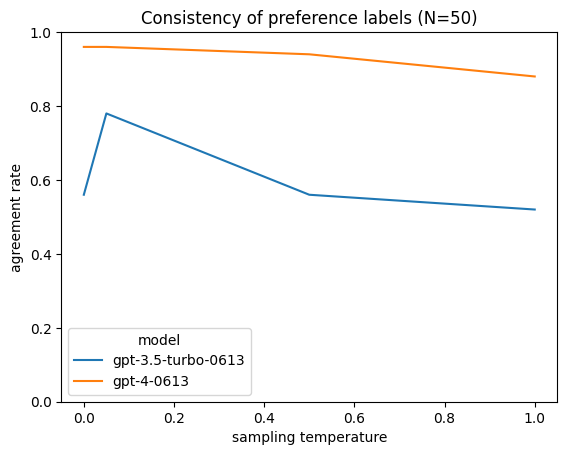

In [17]:
ax = df.groupby(['t', 'model'])["agreement"].mean().unstack().plot(ylim=(0,1), xlabel="sampling temperature", ylabel="agreement rate", title="Consistency of preference labels (N=50)")
ax.figure.savefig("gpt-consistency.png")